## Tutorial 4
Solving the 1D unsteady diffusion equation using a Physics Informed Neural Network (PINN).  
The Equation is given by:
$$\frac {\partial u} {\partial t} - \mu \frac {\partial^2 u} {\partial x^2} = 0$$
The Domain for $x$ and $t$ are $x\in [0,1]$, and $t\in [0,1]$.  
The ICs/BSs are (here $T=1$):
$$u(x,t=0)=sin(\frac {2\pi x} {T})$$
$$u(x=0,t)=0$$
$$u(x=1,t)=0$$
$$u_x(x=0,t)=u_x(x=1,t)$$


In [1]:
import torch
import torch.nn as nn
from torch.autograd import grad
import torch.functional as F
import numpy as np
import matplotlib.pyplot as plt

### Define PINNs network class with Fourier Feature Mapping

In [2]:
class ffm(nn.Module):
    def __init__(self, in_dim, out_dim, std_dev = 10):
        super().__init__()
        self.omega = nn.Parameter(torch.randn(out_dim, in_dim) * std_dev) # Length of hidden layer is rows, 

    def forward(self, x):
        return torch.cos(F.F.linear(x, self.omega))
    
class ffm2(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.B = nn.Parameter(torch.normal(mean=0, std=10, size=(in_dim, out_dim), requires_grad=False))
    
    def forward(self, x):
        x_map = torch.matmul(x, self.B)
        return torch.cat([torch.cos(x_map), torch.sin(x_map)], -1)

class PINNs_net(nn.Module):    
    def __init__(self, in_dim=2, HL_dim=64, out_dim=3, activation=nn.Tanh()):
        """
        Parameters
        -------------
        in_dim: the input dimensions - number of independant variables
        HL_dim: the width of the network
        out_dim: the output dimensions - number of dependant variables
        activation: The activation function you wish to use in the network - the default is nn.Tanh()
        """
        super().__init__()
        
        # define the network architecture
        # network = [nn.Linear(in_dim, HL_dim), activation,
        #            nn.Linear(HL_dim, HL_dim), activation,
        #            nn.Linear(HL_dim, HL_dim), activation,
        #            nn.Linear(HL_dim, HL_dim), activation,
        #            nn.Linear(HL_dim, out_dim)]
        network = [ffm2(in_dim, HL_dim),
                   nn.Linear(HL_dim*2, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, out_dim)]
        
        # define the network using sequential method
        self.net = nn.Sequential(*network) 
    
    def forward(self, x, y):
        return self.net(torch.cat((x, y), 1))
    
    
    def compute_loss(self, x, y, Nx, Ny, u_i):
        """
        This is the physics part really
        """
        Re = 100
        x.requires_grad=True
        y.requires_grad=True
        net_out = self.net(torch.cat((x,y), 1))   # input size: [Nx*Ny,2], output size: [Nx*Ny,3]

        u = net_out[:,0]
        v = net_out[:,1]
        p = net_out[:,2]
        print(type(u))
        # u.requires_grad=True
        # v.requires_grad=True
        # p.requires_grad=True

        # compute PDE derivatives using auto grad
        # we need to specify the dimension of the output array
        u_x = grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_y = grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_yy = grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

        v_x = grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]  # Change 5: Added gradients for v
        v_y = grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        v_xx = grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
        v_yy = grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]

        p_x = grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
        p_y = grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]

        # set a loss function to apply to each of the physics residuals (PDE, IC, BC)
        loss_fun = nn.MSELoss()

        # compute the PDE residual loss
        res1 = u_x + v_y
        res2 = u*u_x + v*u_y + p_x - 1/Re*(u_xx+u_yy)
        res3 = u*v_x + v*v_y + p_y - 1/Re*(v_xx+v_yy)
        pde_loss = loss_fun(res1, torch.zeros_like(res1)) + loss_fun(res2, torch.zeros_like(res2)) + loss_fun(res3, torch.zeros_like(res3))

        # compute the BC loss
        u_reshaped = u.view(Nx, Ny) # [Nx*Ny, 1] -> [Nx, Nt]
        #u_x_reshaped = u_x.view(Nx, Ny) # [Nx*Ny, 1] -> [Nx, Nt]
        v_reshaped = v.view(Nx, Ny) # [Nx*Ny, 1] -> [Nx, Nt]
        #v_x_reshaped = v_x.view(Nx, Ny) # [Nx*Ny, 1] -> [Nx, Nt]
        #u_reshaped = u.view(Nx, Ny) # [Nx*Ny, 1] -> [Nx, Nt]
        #u_x_reshaped = u_x.view(Nx, Ny) # [Nx*Ny, 1] -> [Nx, Nt]
        bc_loss = loss_fun(u_reshaped[0, :], torch.zeros_like(u_reshaped[0,:])) \
                + loss_fun(u_reshaped[-1, :], torch.zeros_like(u_reshaped[Nx-1,:])) \
                + loss_fun(v_reshaped[0, :], torch.zeros_like(v_reshaped[0,:])) \
                + loss_fun(v_reshaped[-1, :], torch.zeros_like(v_reshaped[Nx-1,:])) \
                + loss_fun(u_reshaped[:, 0], torch.zeros_like(u_reshaped[:,Ny-1])) \
                + loss_fun(v_reshaped[:,0], torch.zeros_like(v_reshaped[:,Ny-1])) \
                + loss_fun(u_reshaped[:, -1], u_i * torch.ones_like(u_reshaped[:,0])) \
                + loss_fun(v_reshaped[:, -1], torch.zeros_like(v_reshaped[:,0])) \
        
    
        return pde_loss, bc_loss


### Define Model and Optimizer

In [3]:
model = PINNs_net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Setting up the Case

In [4]:
# num of points in the domain
Nx, Ny = 100, 100
u_i = 5 #m/s
# define domain dimensions and resolution
Lx_initial, Lx_final = 0, 1
Ly_initial, Ly_final = 0, 1
dx = (Lx_final - Lx_initial) / (Nx - 1)
dy = (Ly_final - Ly_initial) / (Ny-1)

# initiallize input parameters as tensors
x = torch.zeros(Nx, Ny)
y = torch.zeros(Nx, Ny)
for i in range(Nx):
    for j in range(Ny):
        x[i,j] = Lx_initial + dx * i
        y[i,j] = Ly_initial + dy * j
print(type(x))
print(x.shape)

<class 'torch.Tensor'>
torch.Size([100, 100])


### Training the PINNs network

In [5]:
for epoch in range(500):
    # compute various losses
    eq_loss, BC_loss = model.compute_loss(x.view(-1,1), y.view(-1,1), Nx, Ny , u_i)

    # compute total loss
    total_loss = eq_loss + 10*BC_loss

    # backward pass
    total_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    print(f"epoch: {epoch}, loss: {total_loss}")


<class 'torch.Tensor'>
epoch: 0, loss: 246.4530792236328
<class 'torch.Tensor'>
epoch: 1, loss: 239.08602905273438
<class 'torch.Tensor'>
epoch: 2, loss: 232.025390625
<class 'torch.Tensor'>
epoch: 3, loss: 224.85804748535156
<class 'torch.Tensor'>
epoch: 4, loss: 217.26368713378906
<class 'torch.Tensor'>
epoch: 5, loss: 208.97129821777344
<class 'torch.Tensor'>
epoch: 6, loss: 199.7733612060547
<class 'torch.Tensor'>
epoch: 7, loss: 189.55506896972656
<class 'torch.Tensor'>
epoch: 8, loss: 178.3105926513672
<class 'torch.Tensor'>
epoch: 9, loss: 166.15188598632812
<class 'torch.Tensor'>
epoch: 10, loss: 153.31869506835938
<class 'torch.Tensor'>
epoch: 11, loss: 140.1830291748047
<class 'torch.Tensor'>
epoch: 12, loss: 127.21885681152344
<class 'torch.Tensor'>
epoch: 13, loss: 114.93179321289062
<class 'torch.Tensor'>
epoch: 14, loss: 103.76685333251953
<class 'torch.Tensor'>
epoch: 15, loss: 94.04876708984375
<class 'torch.Tensor'>
epoch: 16, loss: 85.99470520019531
<class 'torch.Tens

x_np:  (100, 100)
x_np:  <class 'numpy.ndarray'>
u:  torch.Size([10000])
v:  torch.Size([10000])
x_np:  (100, 100)
x_np:  <class 'numpy.ndarray'>
x:  torch.Size([100, 100])
x:  <class 'torch.Tensor'>
u:  <class 'torch.Tensor'>


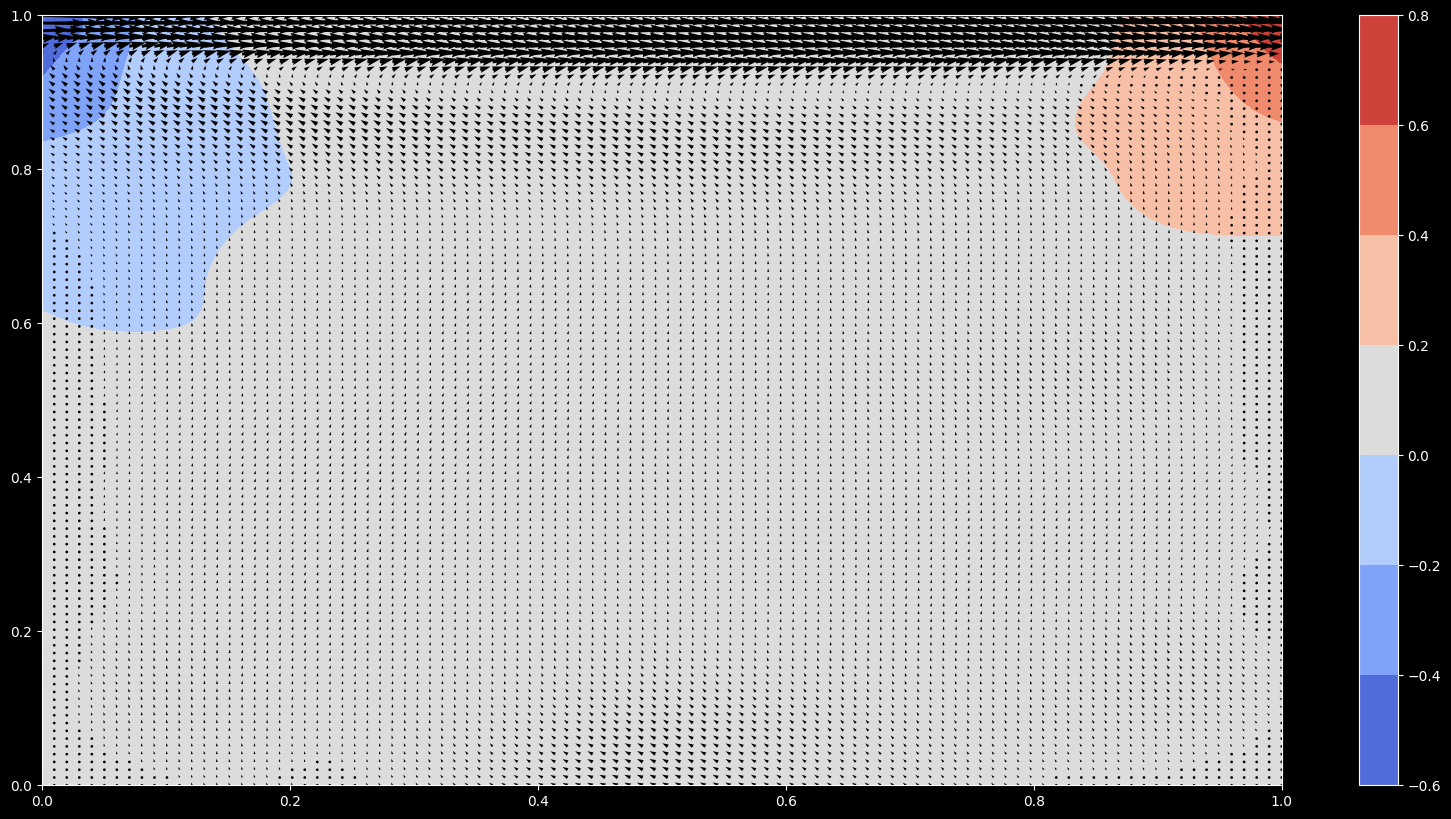

[ 2.37481892e-02  3.51314470e-02  3.51137891e-02  2.82118469e-02
  1.82686821e-02  7.98735023e-03 -1.18477643e-03 -8.85310769e-03
 -1.52959824e-02 -2.10848749e-02 -2.67646164e-02 -3.25908065e-02
 -3.83042246e-02 -4.30782586e-02 -4.57562357e-02 -4.53835577e-02
 -4.17751819e-02 -3.57815921e-02 -2.89721489e-02 -2.29022950e-02
 -1.84196085e-02 -1.54616237e-02 -1.34027302e-02 -1.15963519e-02
 -9.71694291e-03 -7.77564943e-03 -5.92078269e-03 -4.21859324e-03
 -2.54683197e-03 -6.68376684e-04  1.54204667e-03  3.87643278e-03
  5.72246313e-03  6.26029074e-03  4.86768782e-03  1.49334967e-03
 -3.21492553e-03 -8.13224912e-03 -1.20609254e-02 -1.41037554e-02
 -1.38391107e-02 -1.13463104e-02 -7.17195868e-03 -2.24138796e-03
  2.35711038e-03  5.70330024e-03  7.40496814e-03  7.80576468e-03
  7.85517693e-03  8.63750279e-03  1.06420517e-02  1.33268535e-02
  1.53656080e-02  1.54868811e-02  1.32348761e-02  9.06057656e-03
  3.83178890e-03 -1.76087022e-03 -7.44904578e-03 -1.33230686e-02
 -1.95776969e-02 -2.63468

In [8]:
#  x_np, y_np = np.meshgrid(x, y)
x_np = x.detach().numpy()
y_np = y.detach().numpy()
print("x_np: ",x_np.shape)
print("x_np: ",type(x_np))
net = model.forward(x.view(-1,1), y.view(-1,1)) # convert x tensor into a column vector
u=net[:, 0]
v=net[:, 1]
p=net[:, 2]
print("u: ",u.shape)
print("v: ",v.shape)

print("x_np: ",x_np.shape)
print("x_np: ",type(x_np))

print("x: ",x.shape)
print("x: ",type(x))
print("u: ",type(u))

u_np = 1*u.detach().numpy().reshape(Nx,Ny) # convert into a np array
v_np = 1*v.detach().numpy().reshape(Nx,Ny) # convert into a np array
p_np = p.detach().numpy().reshape(Nx,Ny) # convert into a np array

plt.style.use("dark_background")
plt.figure(figsize=(20, 10))
plt.contourf(x_np , y_np, p_np, cmap="coolwarm")
plt.colorbar()

plt.quiver(x_np , y_np , u_np , v_np , color="black")
#plt.streamplot(x_np, y_np, u_np, v_np, color="red")
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()
print(u_np[0,:])

print("max u(x=0) : " , u_np[0,1:-1].max() )
print("max v(x=0) : " , v_np[0].max() )

In [10]:
print(BC_loss)
print(eq_loss)

tensor(0.7231, grad_fn=<AddBackward0>)
tensor(1.9576, grad_fn=<AddBackward0>)


In [7]:
# once you have a complicated solution so the NN is finding it hard to learn functions.
# to enhance the convergance is 
# MLPs can't capture high frequency details. The proposed solution is FFM
# Fourier feature mapping
# PINNs compared to Numerical Solvers is garbage because high frequency data is not captured.
# CFD simulations are usually done in FORTRAN 